In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
from fastai import *
from fastai.vision import *

数据下载地址：http://www.cs.toronto.edu/~nitish/unsupervised_video/

In [3]:
data = np.load('./mnist_test_seq.npy')

In [4]:
data.shape #20张图片，10000个sample，1通道的64 * 64图片

(20, 10000, 64, 64)

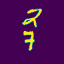

In [5]:
Image(torch.from_numpy(data[0, 0, :, :]).unsqueeze(0))

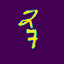

In [6]:
Image(torch.from_numpy(data[1, 0, :, :]).unsqueeze(0))

from npy: 160000it [00:10, 14711.56it/s]


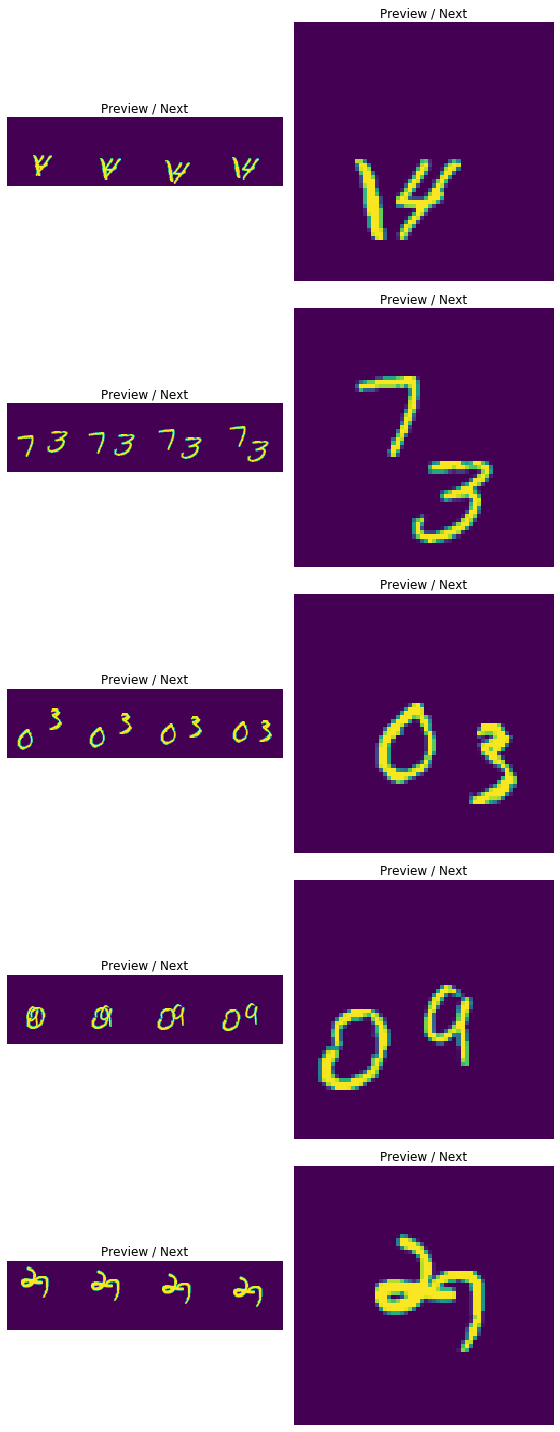

In [7]:
"""
@Time    :2020/1/1 16:06
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json
from torch.utils.data._utils.collate import default_collate
from tqdm import tqdm
import random
from pprint import pprint
import os
from itertools import chain
import collections
from typing import List, Dict, Tuple
import logging
from collections import Iterable
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
from fastai import *
from fastai.vision import *


class ConsImage(ItemBase):
    def __init__(self, imgs_x: List[Image], imgs_y: List[Image]):
        assert isinstance(imgs_x[0], Image)
        self.imgs_x = imgs_x
        self.imgs_y = imgs_y

    def apply_tfms(self, tfms:Collection, **kwargs):
        for img in chain(self.imgs_x, self.imgs_y):
            img.apply_tfms(tfms, **kwargs)

    def show(self, ax:plt.Axes, **kwargs):
        raise NotImplemented
    def __str__(self):
        return f"{len(self.imgs_x)} {len(self.imgs_y)}"



def generate(data: Tensor, winsize_x, winsize_y):
    assert winsize_x +  winsize_y <= data.shape[0]
    winsize = winsize_x + winsize_y
    for d in data.permute(1,0,2,3):
        assert len(d.shape) == 3
        for i in range(d.shape[0] - winsize + 1):
            yield d[i: i+winsize_x, :, :], d[i+winsize_x: i+winsize_x+winsize_y, :, :]
class TMPImageList(ItemList):
    def reconstruct(self, t:Tensor, x:Tensor=None):
        return Image(torch.cat([w for w in t], -1).unsqueeze(0))
class MyImageList(ItemList):
    _bunch = DataBunch
    _label_cls = TMPImageList

    @classmethod
    def from_npy(cls, file: Path, winsize_x = 3, winsize_y = 3):
        # create ItemList, which contains objects we want
        data = np.load(file)
        data = data/255
        if not isinstance(data, Tensor):
            data = torch.from_numpy(data)
        assert len(data.shape) == 4 # some tensor like: 20, 50, 64, 64
        items = []
        for x, y in tqdm(generate(data, winsize_x, winsize_y), desc="from npy"):
            x = [Image(w.unsqueeze(0)) for w in x]
            y = [Image(w.unsqueeze(0)) for w in y]
            items.append(ConsImage(x, y))
        res = cls(items)
        return res

    def reconstruct(self, t:Tensor, x:Tensor=None):
        return Image(torch.cat([w for w in t], -1).unsqueeze(0))

    # def get(self, i)->Any:
    #     "Subclass if you want to customize how to create item `i` from `self.items`."
    #     return self.items[i]
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = len(xs)

        axs = subplots(rows, 2, imgsize=imgsize, figsize=figsize)
        for i in range(0, len(axs.flatten()),  2):
            ax = axs.flatten()[i]
            index = i // 2
            x = xs[index]
            y = ys[index]
            x.show(ax = ax, **kwargs)
            y.show(ax = axs.flatten()[i+1], **kwargs)
#         for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

def label_func(input):
    # print(type(x))
    # print(x)
    return input.imgs_y

def collate(samples):
    x, y = zip(*samples)
    tensor_x = torch.stack([torch.cat([w.data for w in c.imgs_x]) for c in x])
    tensor_y = torch.stack([torch.cat([w.data for w in c.imgs_y]) for c in x])
    assert len(tensor_x.shape) == len(tensor_y.shape) == 4
    return tensor_x, tensor_y

BATCHSIZE = 32
WIN_ENCODER = 4
WIN_DECODER = 1

# data_pth = Path('./data_samples.npy')
data_pth = Path('./mnist_test_seq.npy')
data = MyImageList.from_npy(data_pth, winsize_x=WIN_ENCODER, winsize_y=WIN_DECODER) # construct MyImageList which contains itembase
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate, num_workers = 0) # to debug, we set

data.show_batch(title = "Preview / Next")

In [8]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, encoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder


from convlstm import *
def get_model():
    encoder = ConvLSTM(input_size=(64, 64),
                 input_dim=1,
                 hidden_dim=[64, 64, 1],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=True)

    decoder = ConvLSTMDeocder(input_size=(64, 64),
                 input_dim=1,
                 hidden_dim=[64, 64, 1],
                 kernel_size=(3, 3),
                 num_layers=3,
                       decode_step = WIN_DECODER,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)
    model = EncoderDecoder(encoder, decoder)
    return model

def loss_func(x, y):
    x = x.view(-1).float()
    y = y.view(-1).float()

    assert len(x) == len(y)
    return F.l1_loss(x, y)

model = get_model()
learner = Learner(data, model, loss_func = loss_func)

In [9]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-05
Min loss divided by 10: 2.51E-04


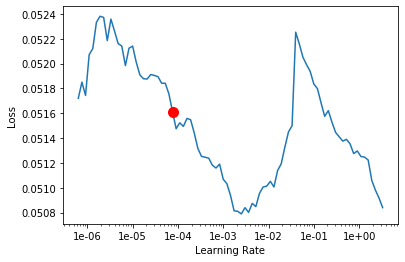

In [10]:
learner.recorder.plot(suggestion = True)

In [11]:
learner.summary()

EncoderDecoder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [256, 64, 64]        150,016    True      
______________________________________________________________________
Conv2d               [256, 64, 64]        295,168    True      
______________________________________________________________________
Conv2d               [4, 64, 64]          2,344      True      
______________________________________________________________________
Conv2d               [256, 64, 64]        150,016    True      
______________________________________________________________________
Conv2d               [256, 64, 64]        295,168    True      
______________________________________________________________________
Conv2d               [4, 64, 64]          2,344      True      
______________________________________________________________________

Total params: 895,056
Total trainable params: 895,056
Total non-trainable params: 0
Optimized with 'torch.opti

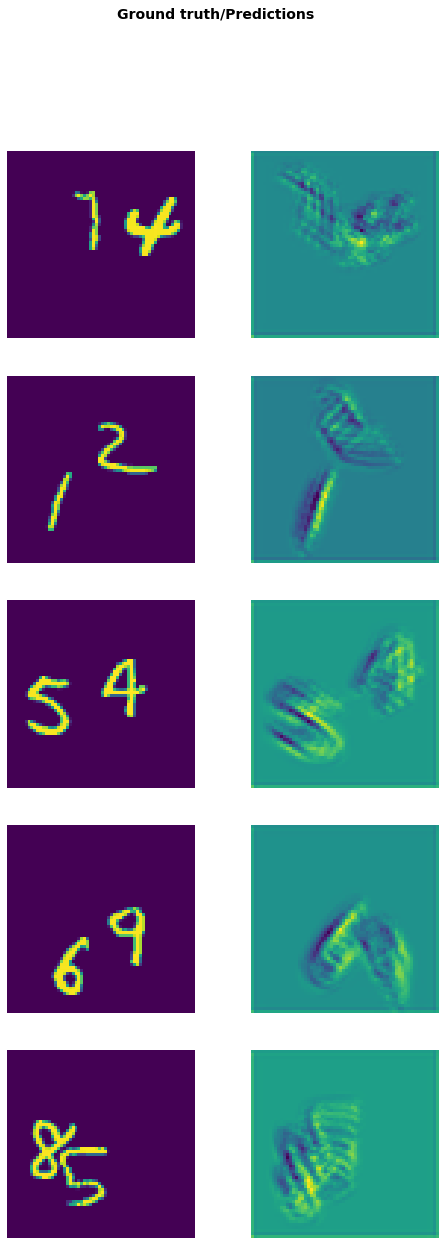

In [12]:
learner.show_results()

In [13]:
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.022427,0.022446,2:43:37


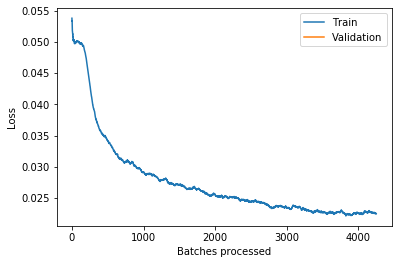

In [14]:
learner.recorder.plot_losses()

In [18]:
learner.save('stage_2h43mins')

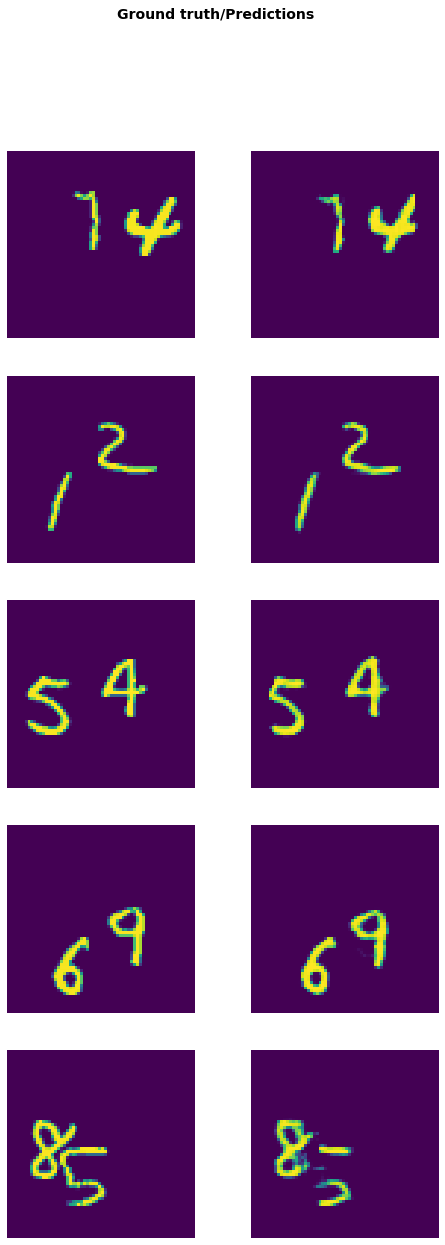

In [16]:
learner.show_results()

from npy: 130000it [00:10, 12616.88it/s]


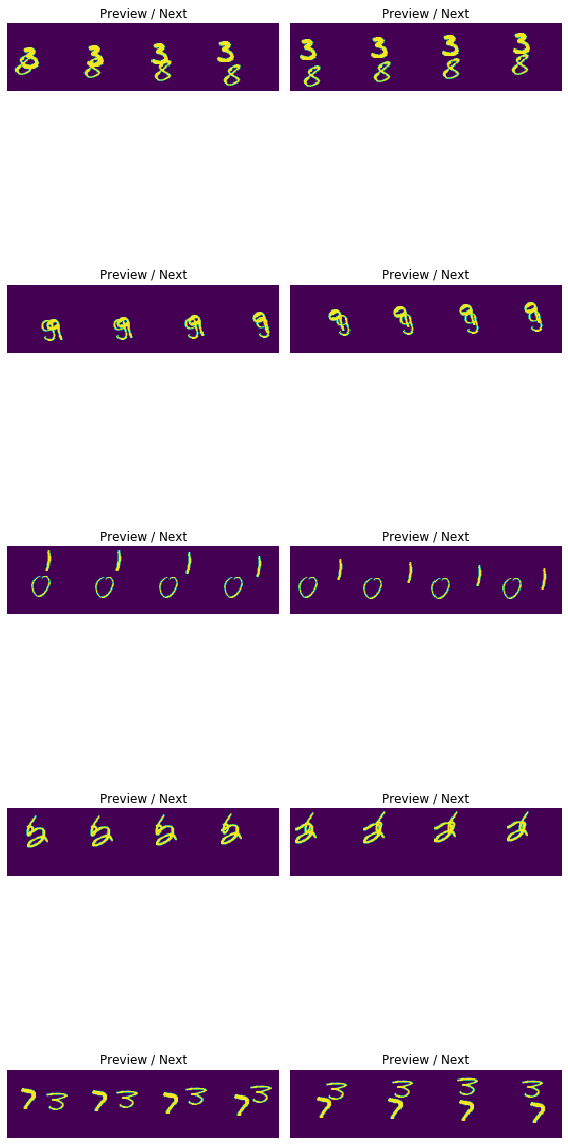

In [46]:
BATCHSIZE = 32
WIN_ENCODER = 4
WIN_DECODER = 4

# data_pth = Path('./data_samples.npy')
data_pth = Path('./mnist_test_seq.npy')
data = MyImageList.from_npy(data_pth, winsize_x=WIN_ENCODER, winsize_y=WIN_DECODER) # construct MyImageList which contains itembase
data = data.split_by_rand_pct(0.15) # ItemLists which contains trains and valids
data = data.label_from_func(label_func)
data = data.databunch(bs = BATCHSIZE, collate_fn = collate) 

data.show_batch(title = "Preview / Next")

In [47]:
model = get_model()
learner = Learner(data, model, loss_func = loss_func)

In [48]:
learner.model.decoder.decode_step

4

In [49]:
learner.load('stage_2h43mins')

Learner(data=DataBunch;

Train: LabelList (110500 items)
x: MyImageList
4 4,4 4,4 4,4 4,4 4
y: TMPImageList
[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)]
Path: .;

Valid: LabelList (19500 items)
x: MyImageList
4 4,4 4,4 4,4 4,4 4
y: TMPImageList
[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)],[Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64) Image (1, 64, 64)]
Path: .;

Test: None, model=EncoderDecoder(
  (encoder): Con

In [50]:
learner.show_resultsone_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.034675,0.034542,3:30:03


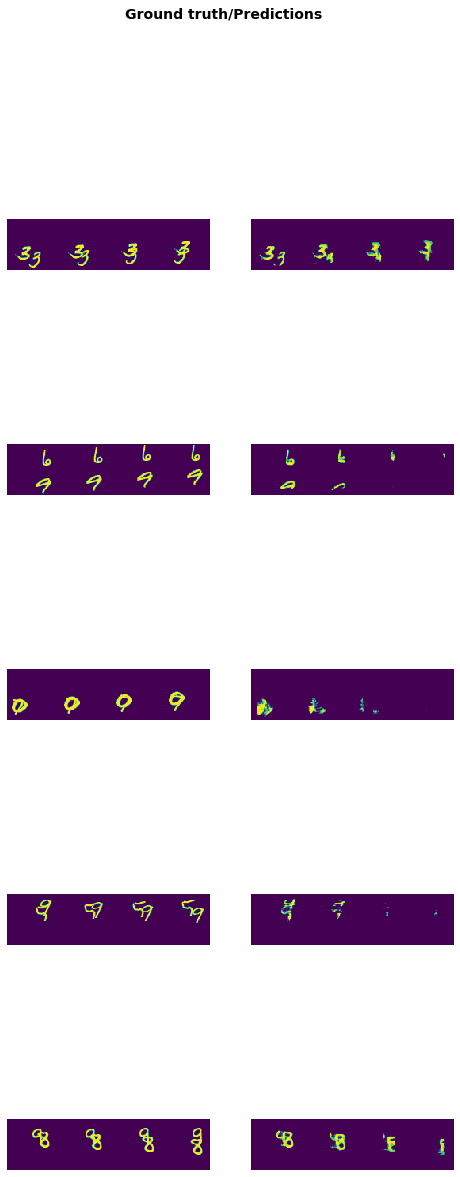

In [51]:
learner.show_results()